In [100]:
import pandas as pd
import numpy as np
import ast
import json
import re
from collections import defaultdict
import matplotlib.pyplot as plt

In [101]:
df = pd.read_csv('data/final_dataset_reduced.csv')
print(len(df))

32028


In [102]:
default_social_tags = {
 "Ariana Grande" : "pop",
 "BTS (방탄소년단)": "pop",
 "Beyoncé": "rnb",
 "Billie Eilish": "indie pop",
 "Cardi B": "hip-hop",
 "Charlie Puth": "pop",
 "Coldplay": "alternative rock",
 "Drake": "hip-hop",
 "Dua Lipa": "pop",
 "Ed Sheeran": "pop",
 "Eminem": "hip-hop",
 "Justin Bieber": "pop",
 "Katy Perry": "pop",
 "Khalid": "rnb",
 "Lady Gaga": "pop",
 "Maroon5": "pop",
 "Nicki Minaj": "hip-hop",
 "Post Malone": "hip-hop",
 "Rihanna": "rnb",
 "Selena Gomez": "pop",
 "Taylor Swift": "pop"
}

In [103]:
dataset_dict_list = df.to_dict('records')

with open('data/good_tags.json', 'r') as fp:
    good_tags = set(json.load(fp))

In [104]:
# dict of tags for each song as a weighted string ie. ["pop pop pop pop", "hip-hop, hip-hop"]
weighted_list_of_str_tags = []

for song_index, row in enumerate(dataset_dict_list):

    song_social_tags = ast.literal_eval(row['social_tags']) if not pd.isna(row['social_tags']) else []
    song_emotion_tags = ast.literal_eval(row['emotion_tags']) if not pd.isna(row['emotion_tags']) else []

    # add default social tag to 21 artists
    if row['artist'] in default_social_tags and len(song_social_tags) == 0:
        song_social_tags = [(default_social_tags[row['artist']], 100)]

    weighted_tags_list = []

    for tag, value in (song_social_tags + song_emotion_tags):
        if tag in good_tags:
            # add the number of tags * (value // 10)
            for i in range(value // 10):
                weighted_tags_list.append(re.sub(r'\W+', '', tag))
    
    weighted_list_of_str_tags.append("` ".join(weighted_tags_list))

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [106]:
vectorizer = TfidfVectorizer()
td_matrix = vectorizer.fit_transform(weighted_list_of_str_tags)
print(td_matrix.shape)

(32028, 169)


In [107]:
feature_names = vectorizer.get_feature_names() 
print(feature_names)

['00s', '1970s', '1990s', '2000s', '60s', '70s', '77davezalltracks', '80s', '90s', 'acoustic', 'aggressive', 'altcountry', 'alternative', 'alternativemetal', 'alternativepunk', 'alternativerock', 'altrock', 'amazing', 'ambient', 'american', 'americana', 'angry', 'angst', 'atmospheric', 'awesome', 'ballad', 'beautiful', 'best', 'bittersweet', 'blue', 'blues', 'bluesrock', 'british', 'britpop', 'calm', 'canadian', 'catchy', 'chill', 'chillout', 'christian', 'classic', 'classicrock', 'cool', 'country', 'cover', 'covers', 'dance', 'dark', 'deathmetal', 'depressing', 'depressive', 'doommetal', 'dreamy', 'driving', 'easylistening', 'electronic', 'electronica', 'emo', 'emotional', 'energetic', 'english', 'epic', 'experimental', 'fav', 'favorite', 'favorites', 'favoritesongs', 'favourite', 'favourites', 'favouritesongs', 'female', 'femalevocalist', 'femalevocalists', 'femalevocals', 'folk', 'folkrock', 'friendsofthekingofrummelpop', 'fuckingawesome', 'fun', 'funk', 'funny', 'german', 'glamrock

In [108]:
from scipy.sparse.linalg import svds
# do SVD with a very large k (we usually use 100), just for the sake of getting many sorted singular values (aka importances)
u,s,v_trans = svds(td_matrix, k=168)

In [109]:
print(u.shape)
print(s.shape)
print(v_trans.shape)

(32028, 168)
(168,)
(168, 169)


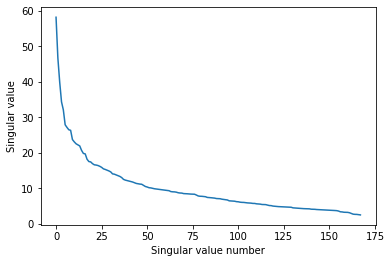

In [110]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [111]:
# these should be the three output matrices -> not sure if rest of code is important (normalization)
songs_compressed, s, tags_compressed = svds(td_matrix, k=25)
tags_compressed = tags_compressed.transpose()

In [112]:
print(tags_compressed.shape)
print(songs_compressed.shape)

(169, 25)
(32028, 25)


/Users/fjordrunner/cs4300-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


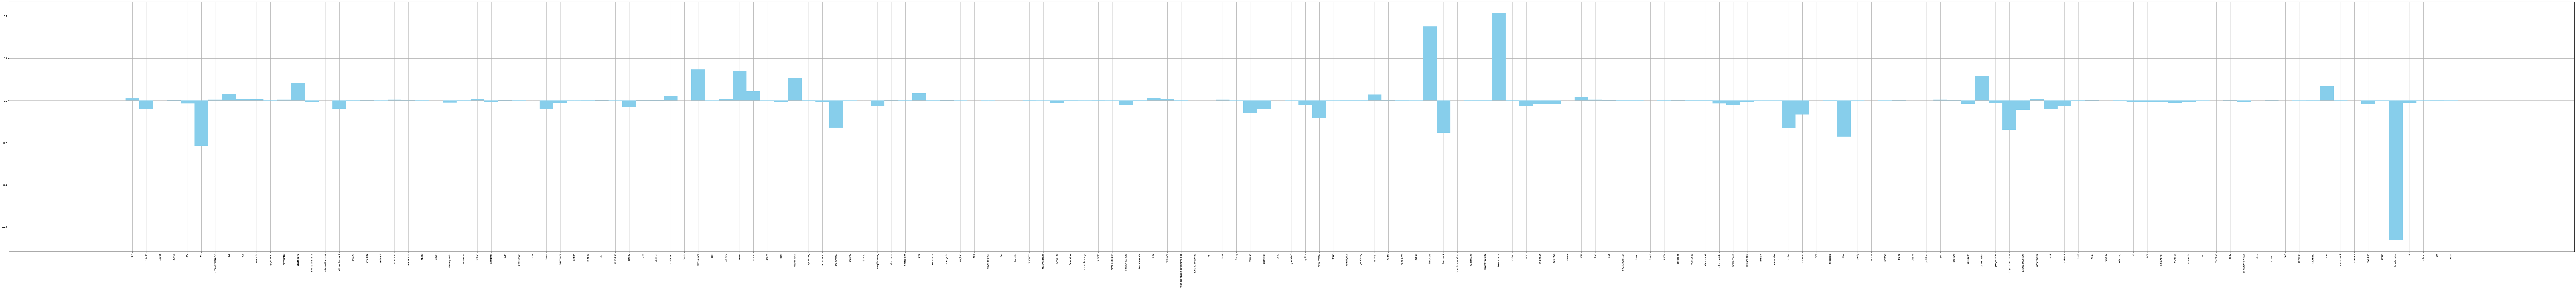

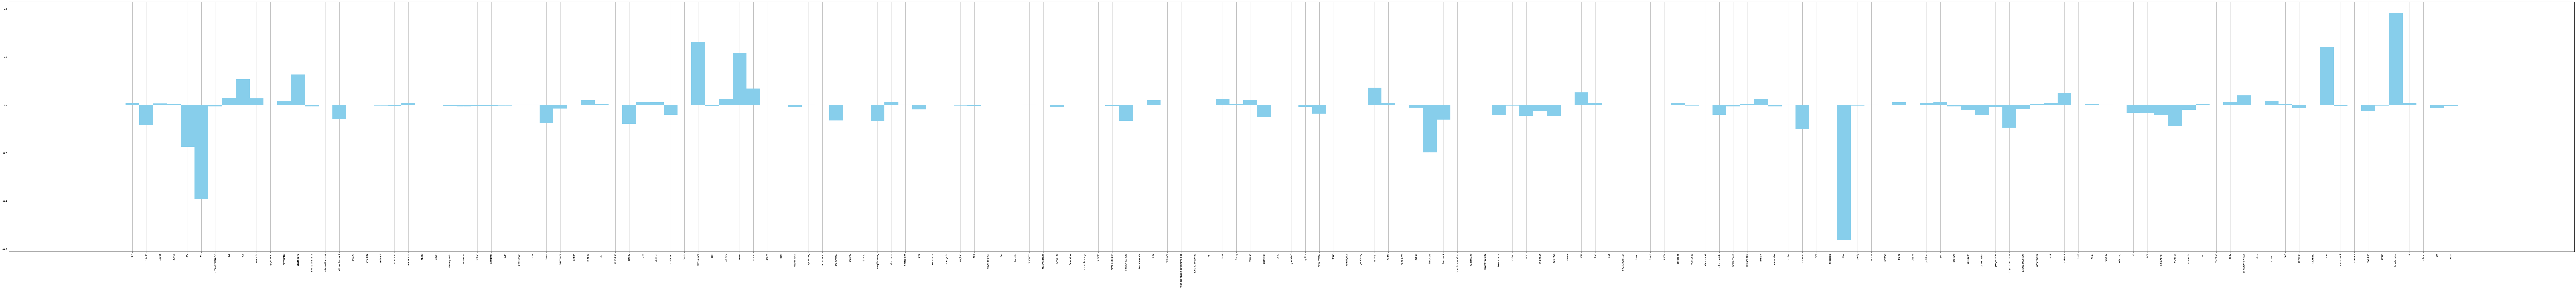

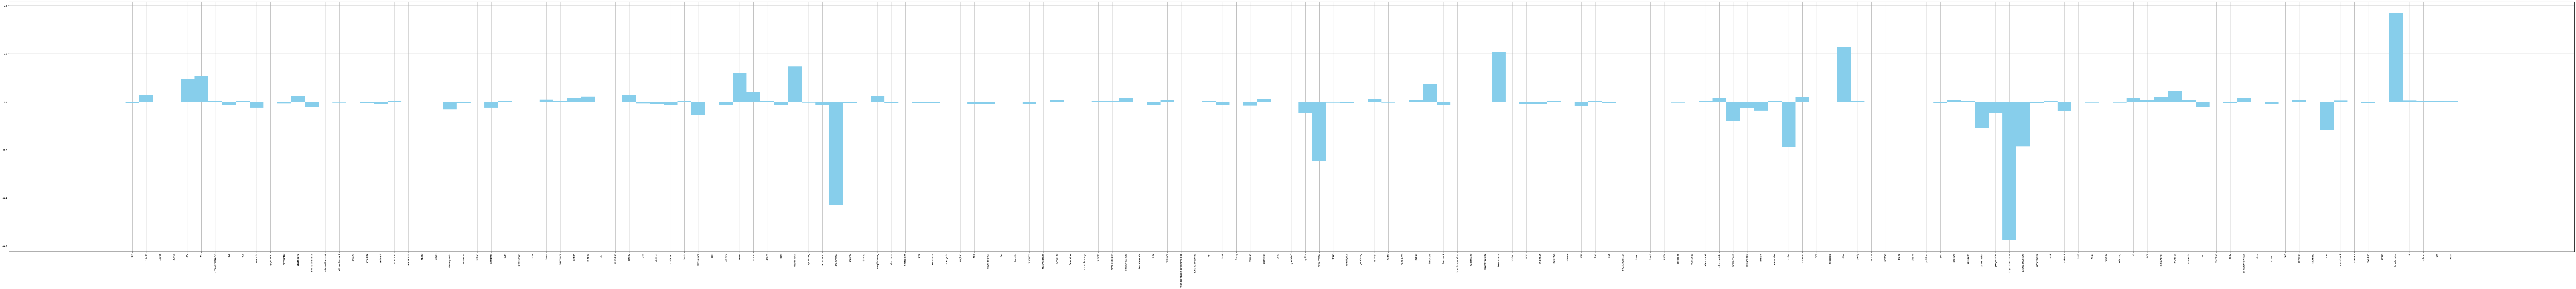

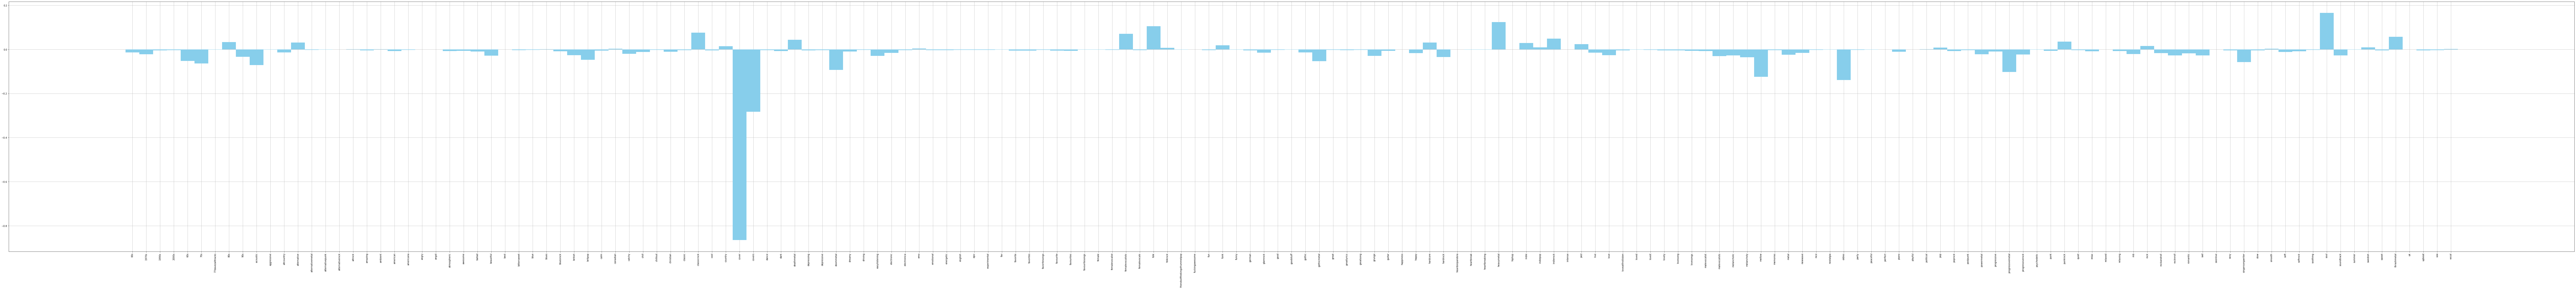

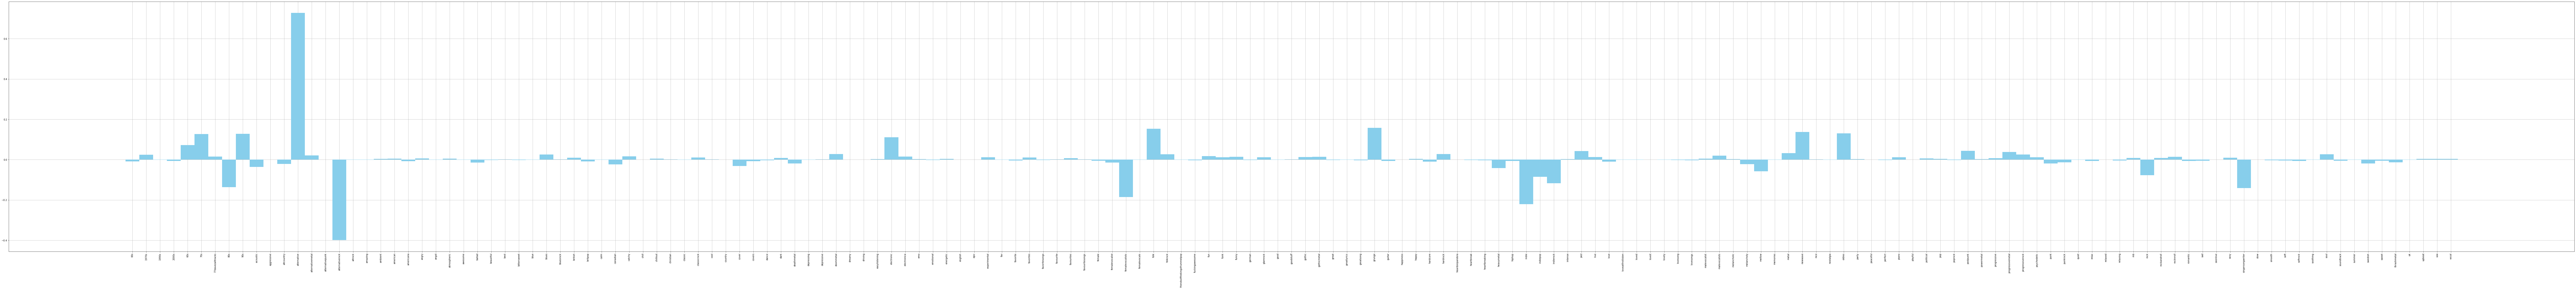

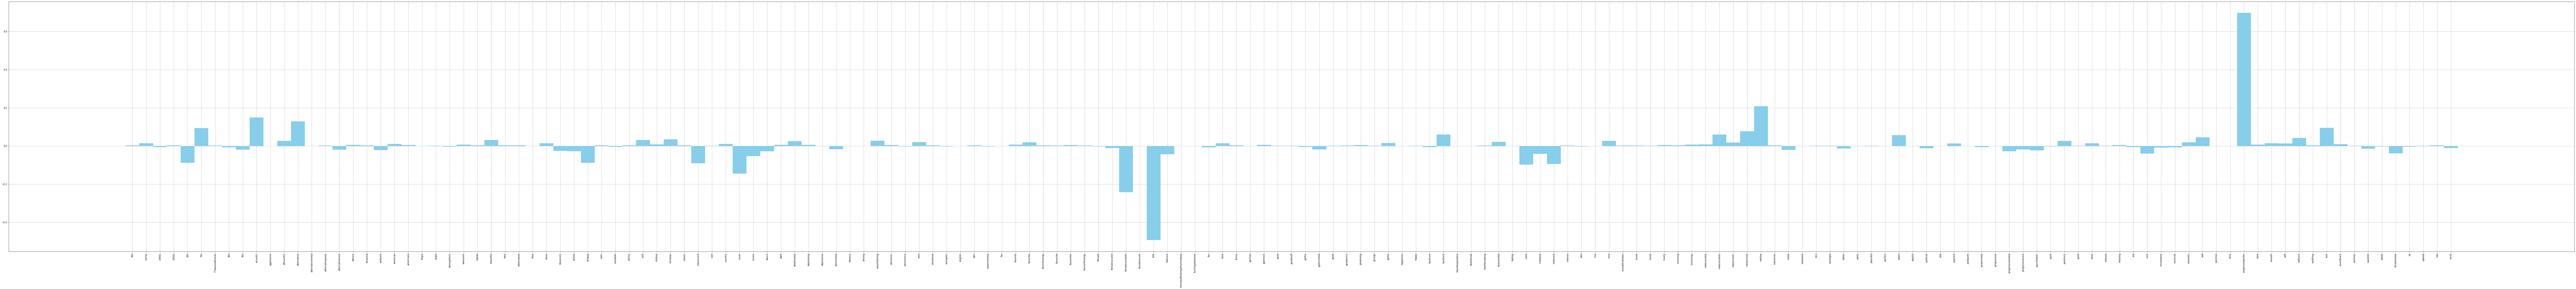

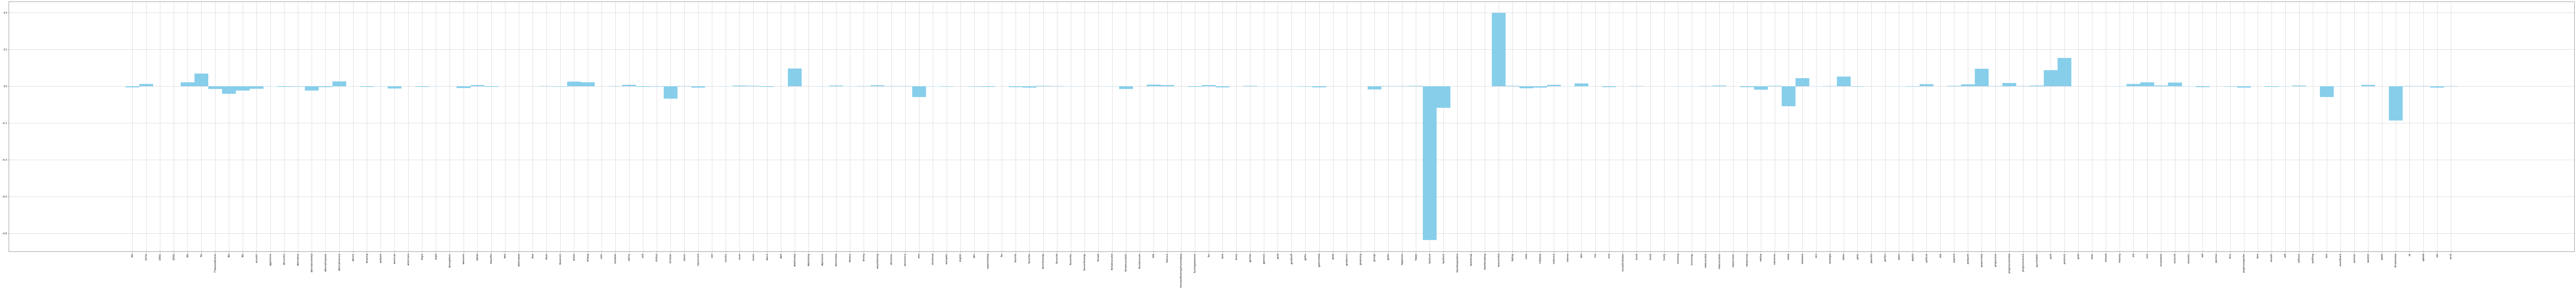

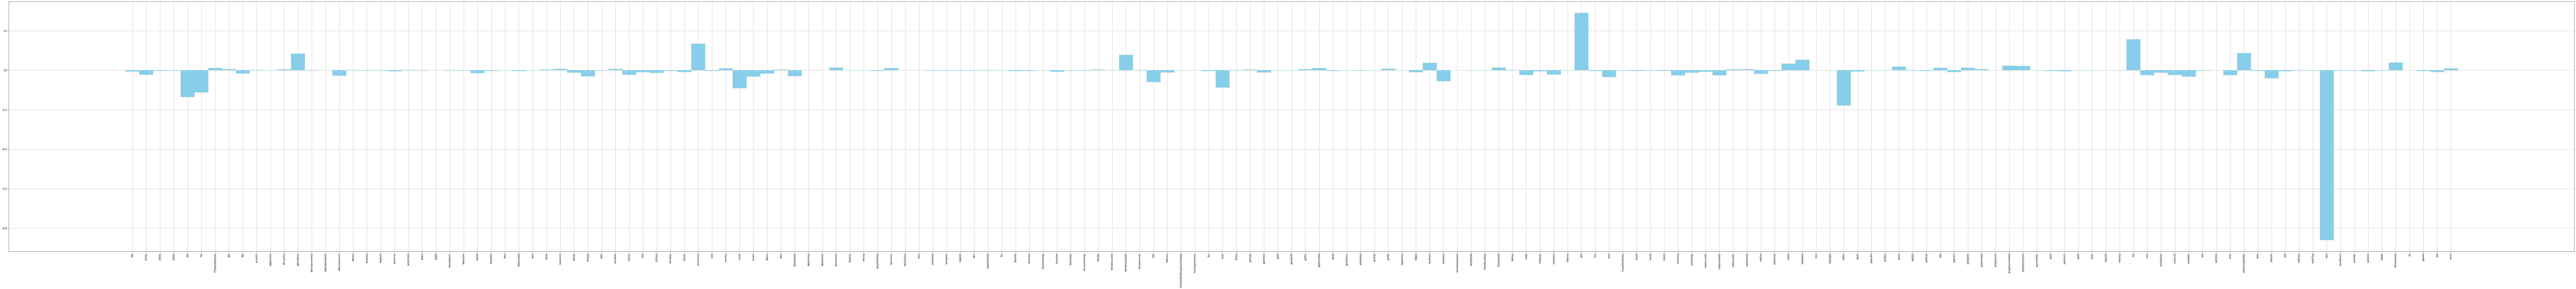

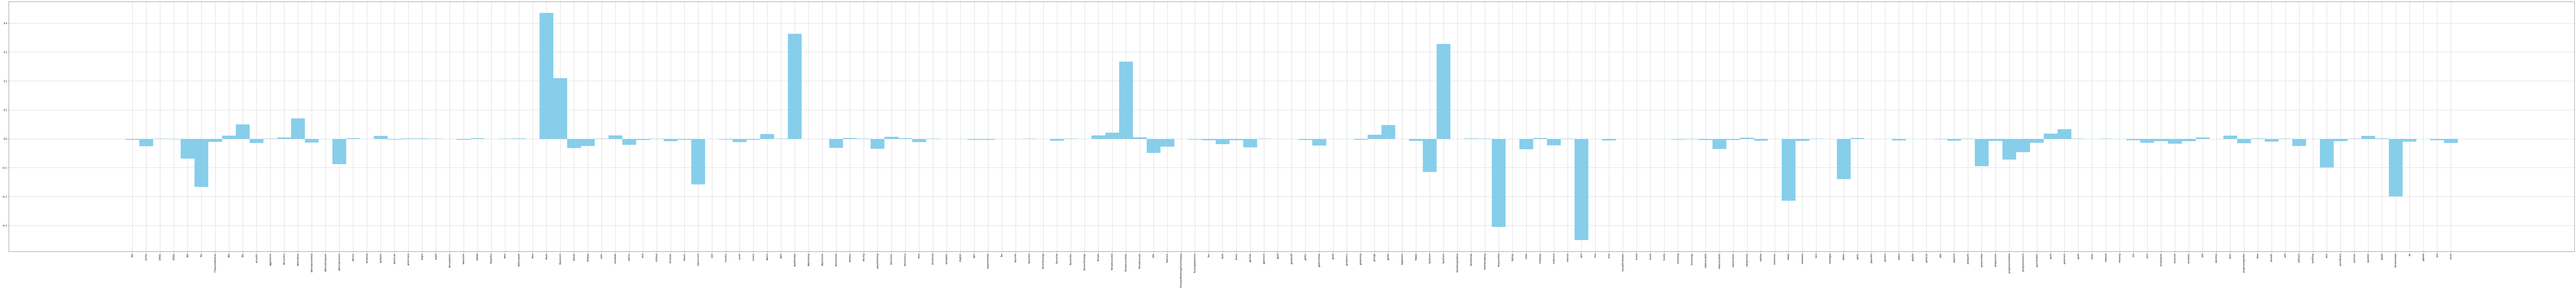

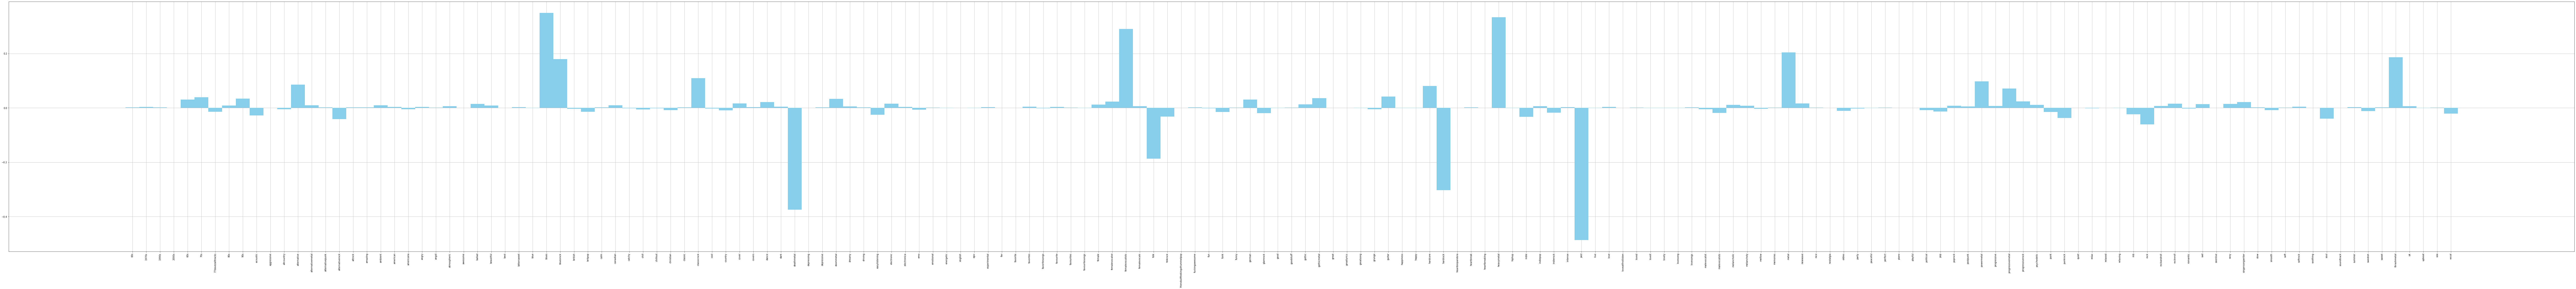

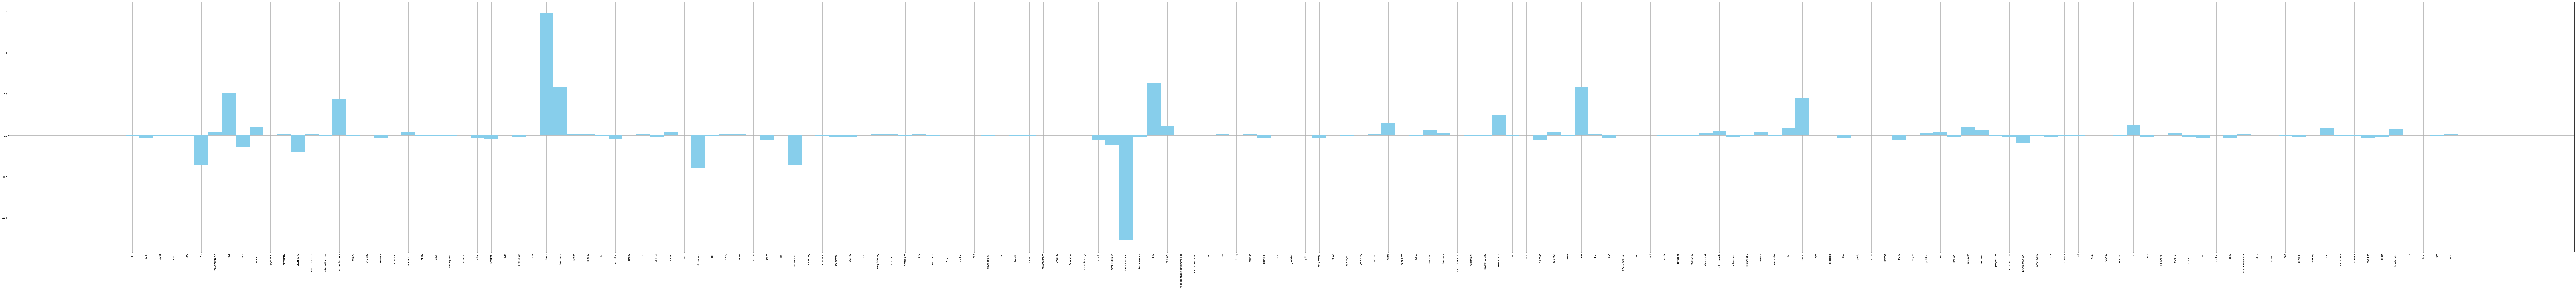

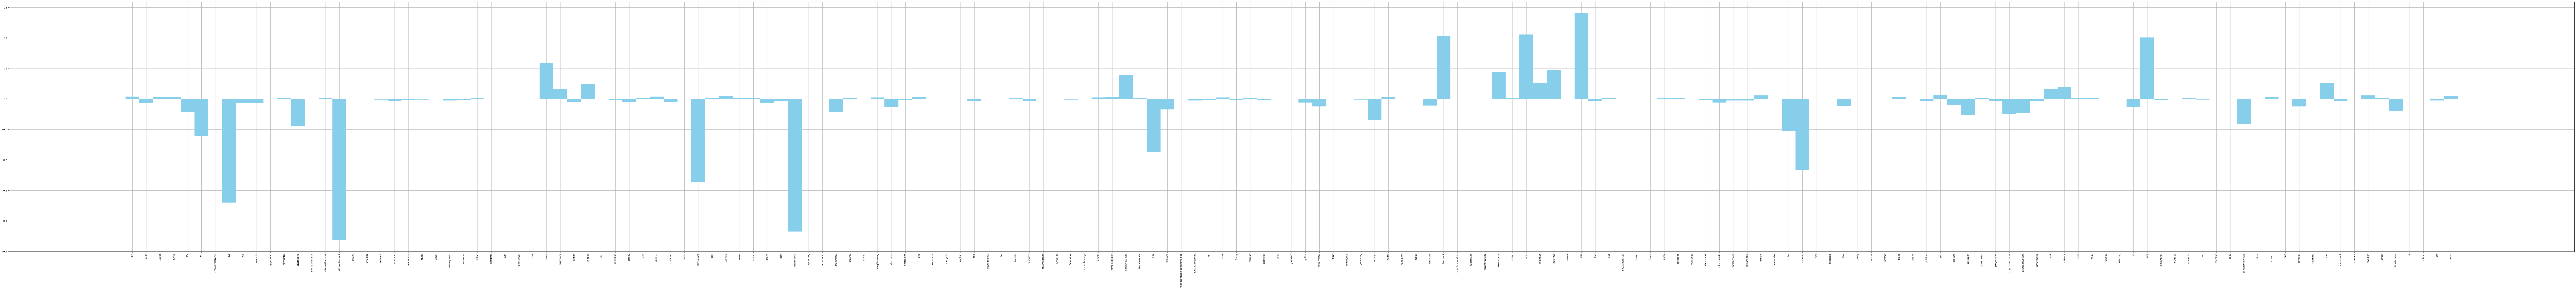

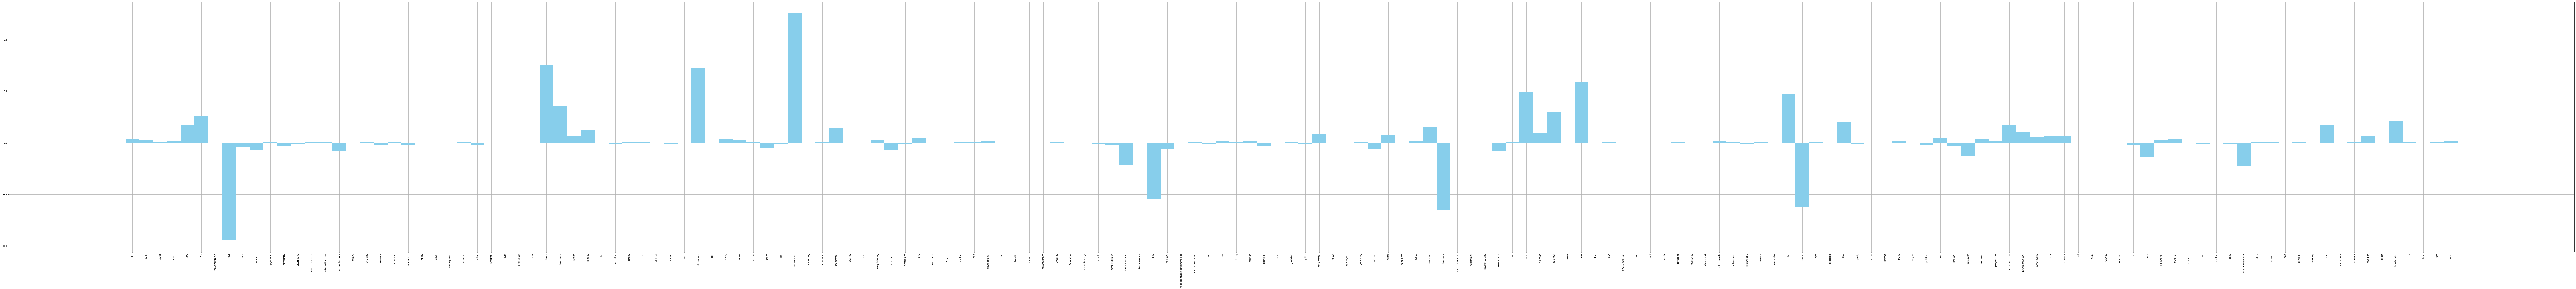

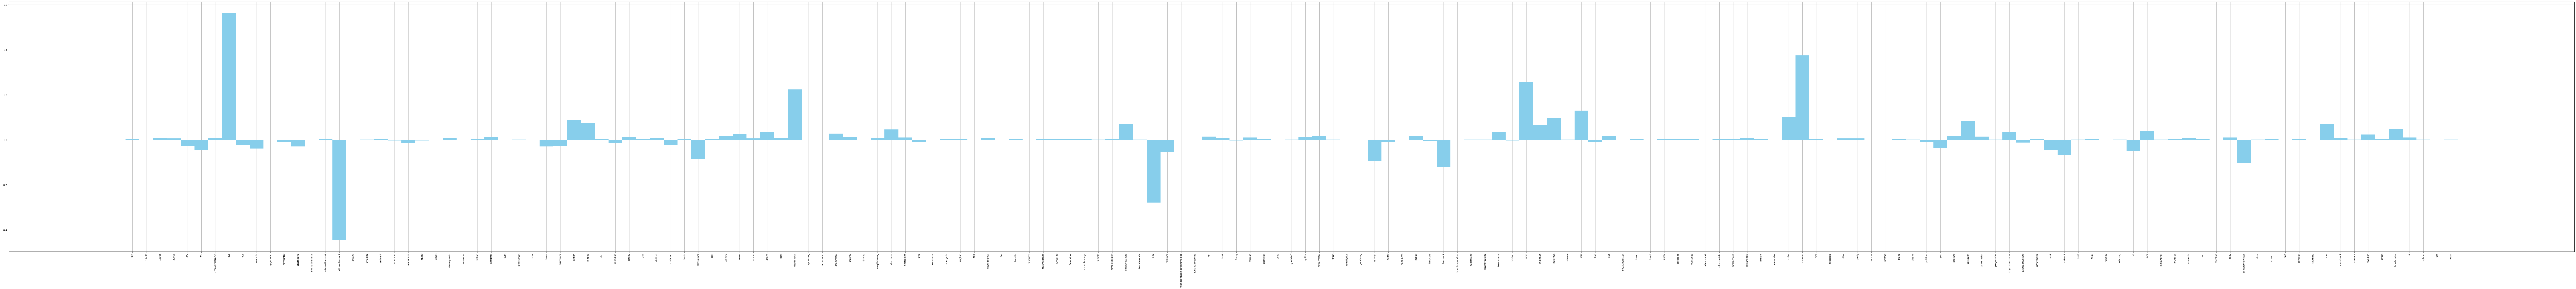

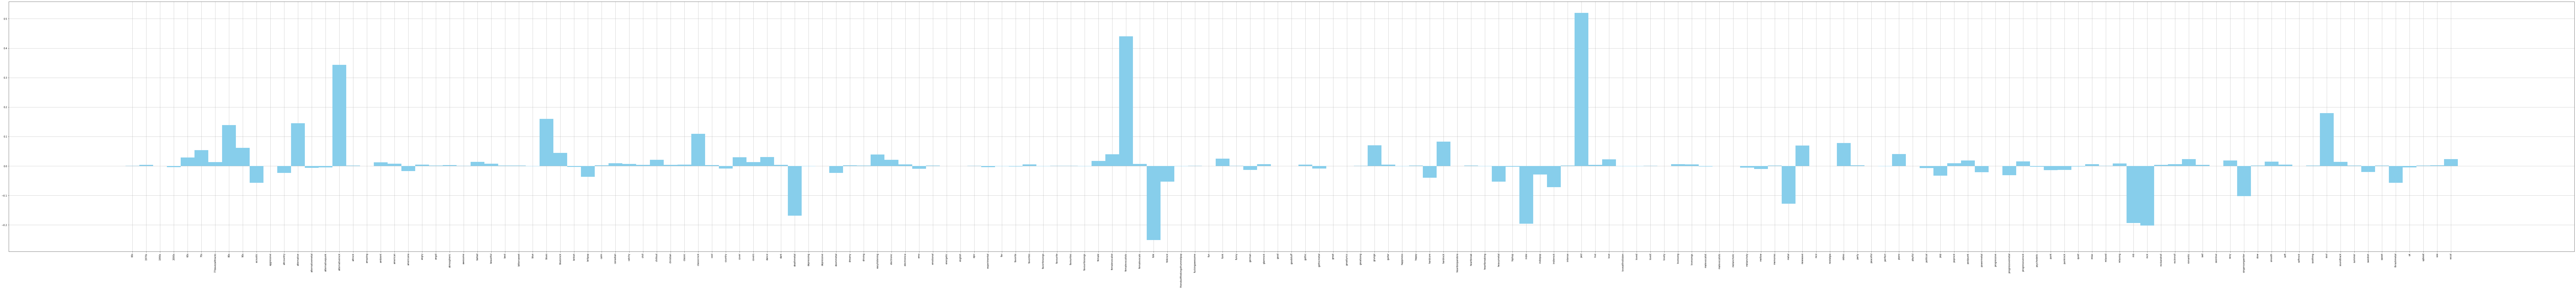

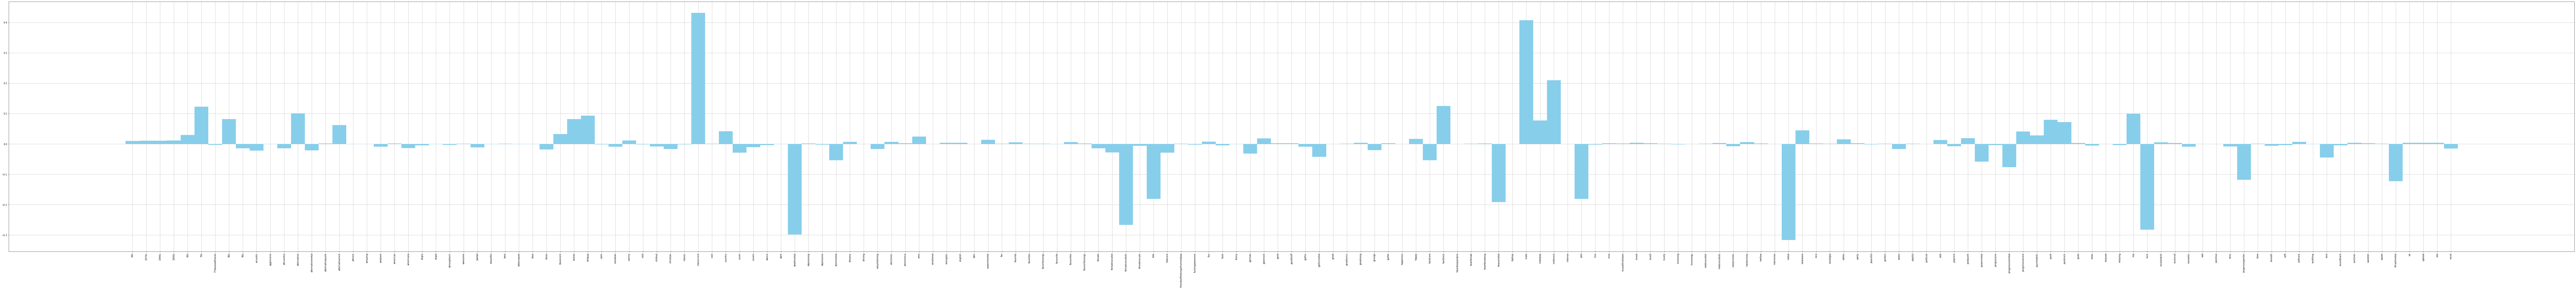

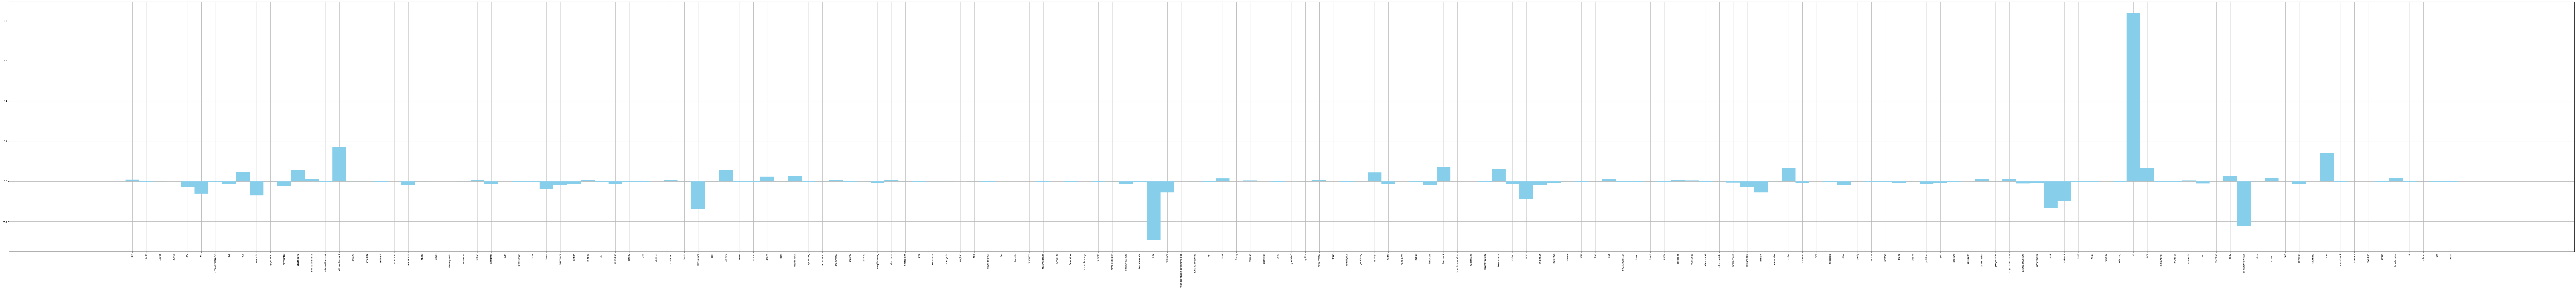

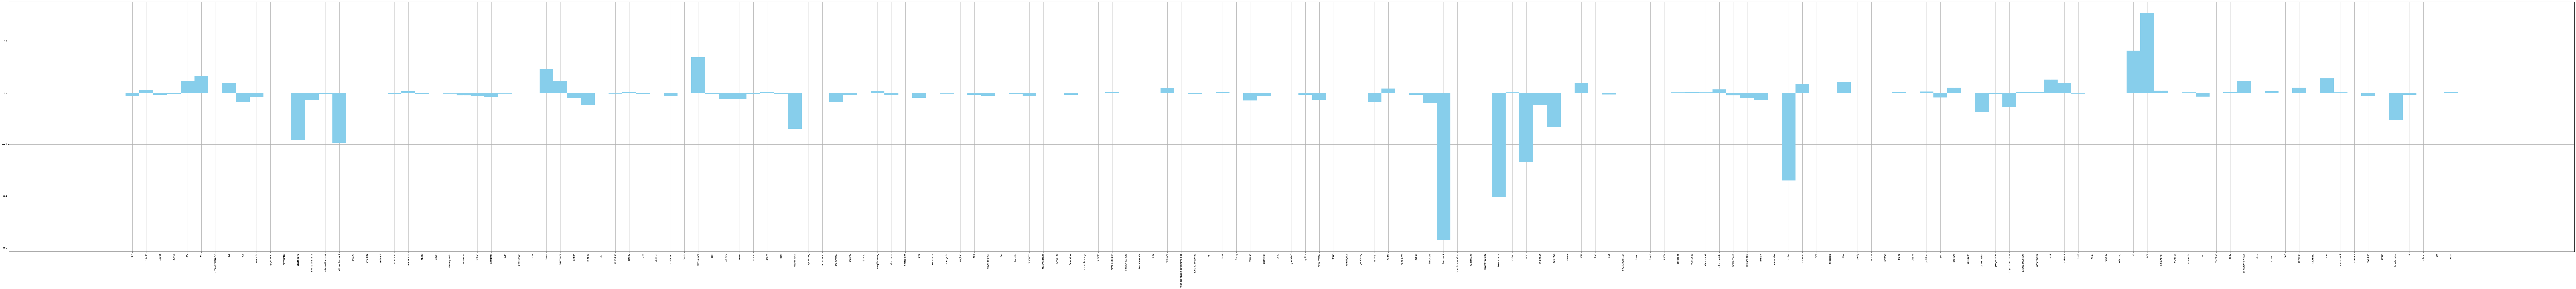

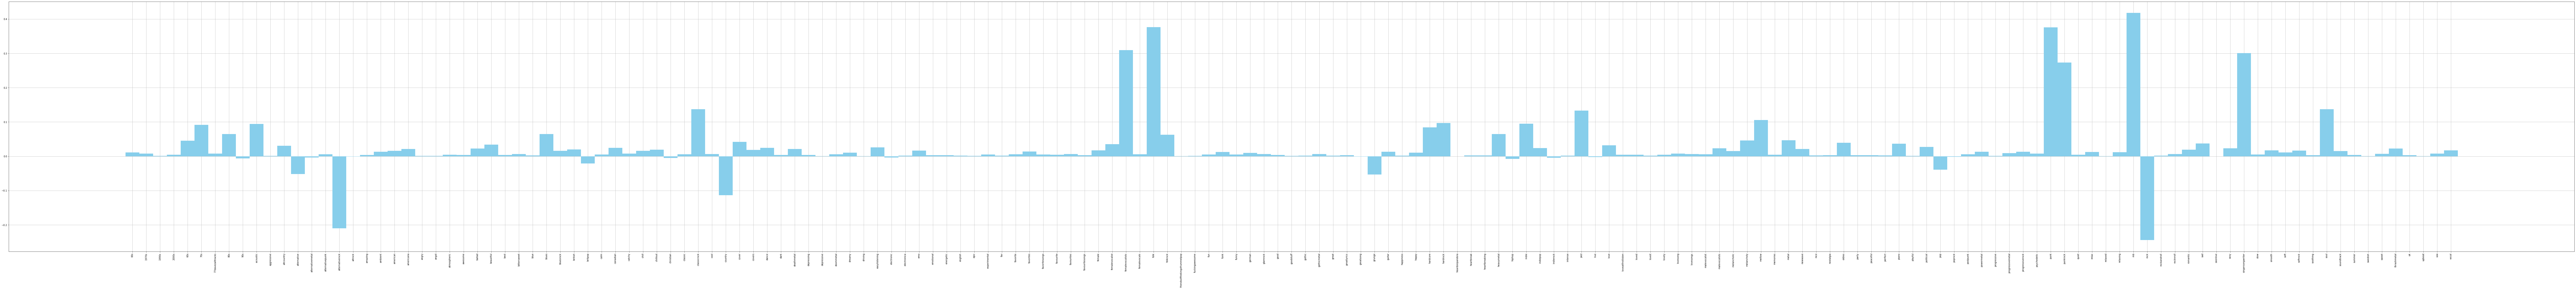

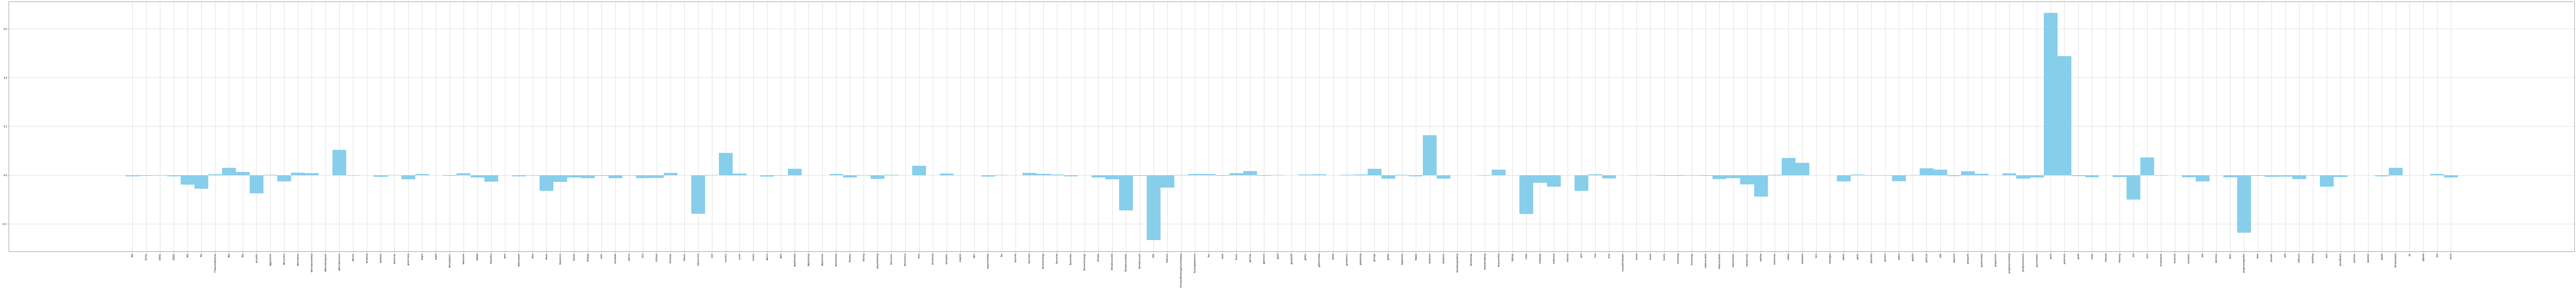

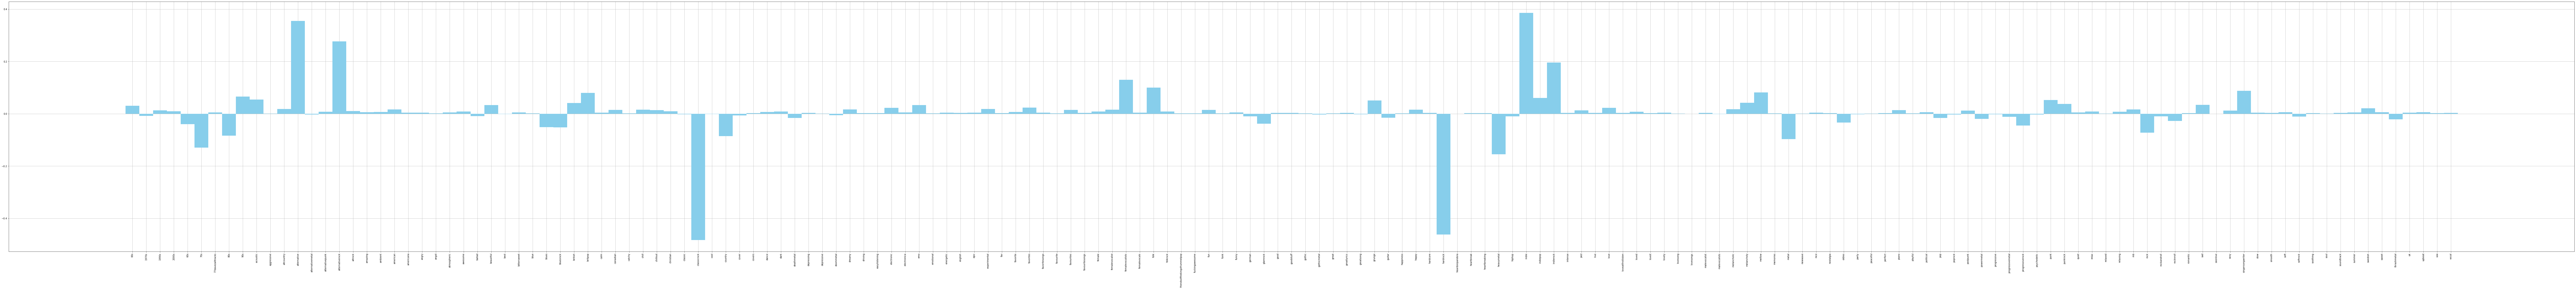

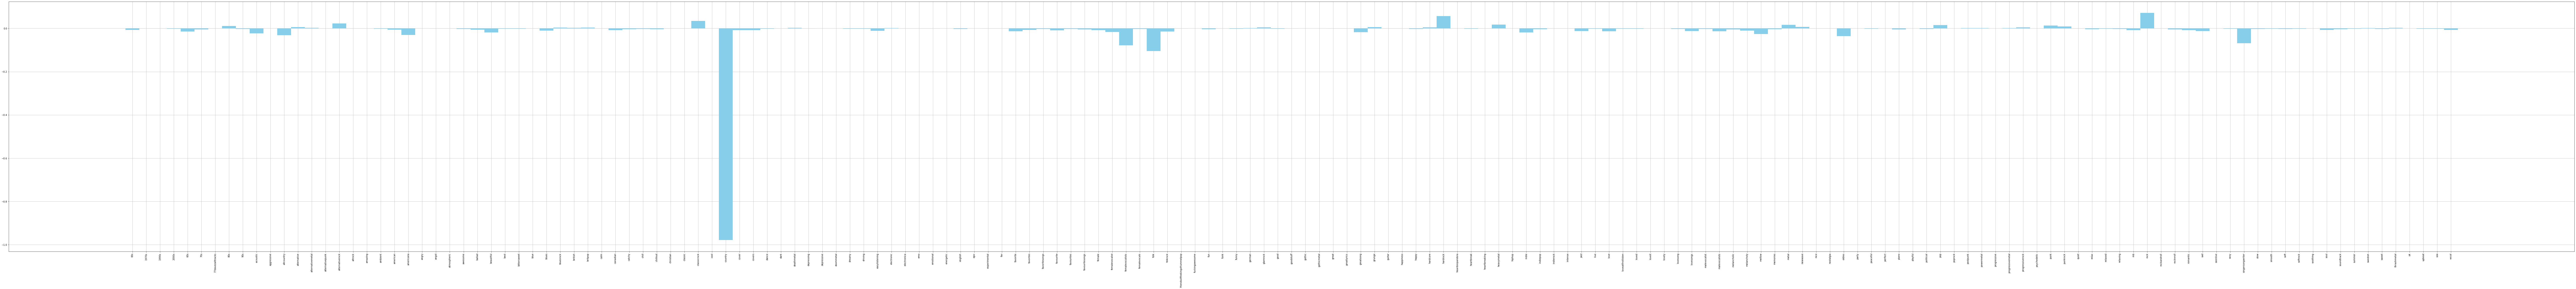

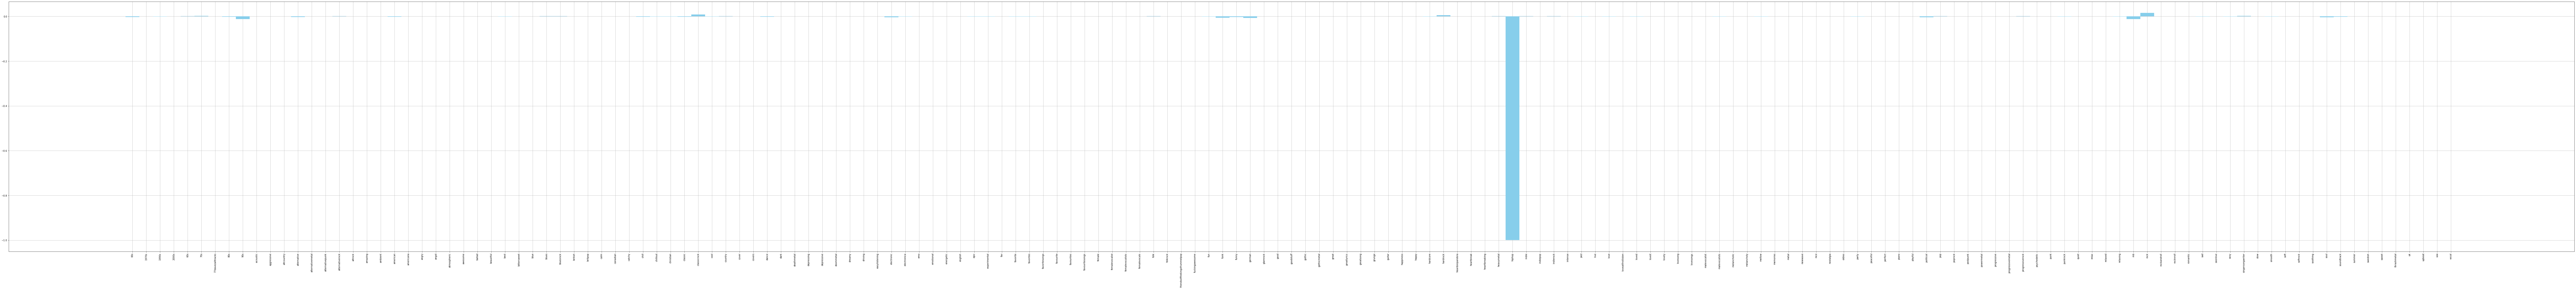

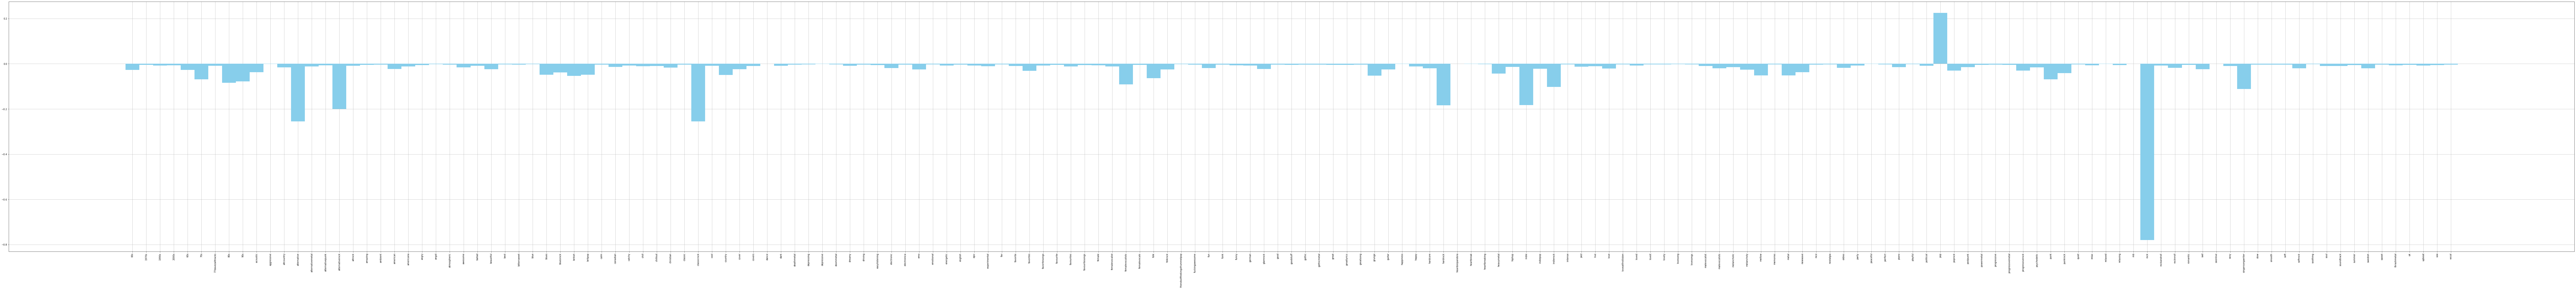

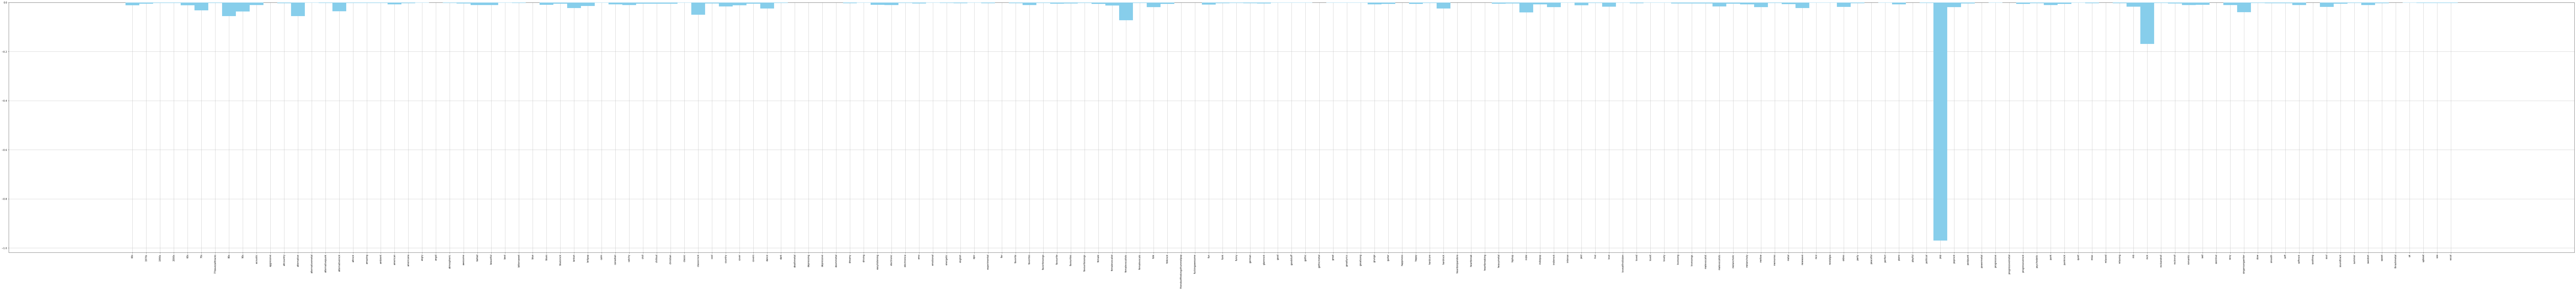

In [113]:
new_tags_by_old_tags = (tags_compressed.T).tolist()

for new_tag_num in range(tags_compressed.shape[1]):

    tag_range = range(len(new_tags_by_old_tags[new_tag_num]))

    fig = plt.figure(figsize=(200, 20))

    ax = fig.add_subplot(111)

    ax.bar(tag_range, new_tags_by_old_tags[new_tag_num], width =1)

    ticks = [(1 * i) for i in tag_range]

    ax.set_xticks(ticks)
    ax.set_xticklabels(feature_names, rotation=90)

    ax.grid(zorder=0)
    ax.bar(tag_range, new_tags_by_old_tags[new_tag_num], width=1, align='center', color='skyblue', zorder=3)

    # plt.show()
    fig.savefig(fname = "./newtag" + str(new_tag_num) + "_relations.png")


In [68]:
# word_to_index = vectorizer.vocabulary_
# index_to_word = {i:t for t,i in word_to_index.items()}
# print(tags_compressed.shape)

In [53]:
# from sklearn.preprocessing import normalize
# words_compressed_normed = normalize(tags_compressed, axis = 1)

In [54]:
# def closest_words(word_in, words_representation_in, k = 10):
#     if word_in not in word_to_index: return "Not in vocab."
#     sims = words_representation_in.dot(words_representation_in[word_to_index[word_in],:])
#     asort = np.argsort(-sims)[:k+1]
#     return [(index_to_word[i],sims[i]) for i in asort[1:]]

In [ ]:
# td_matrix_np = td_matrix.transpose().toarray()
# td_matrix_np = normalize(td_matrix_np)